<a href="https://colab.research.google.com/github/lse-st446/lectures2021/blob/master/Week11/class/mnist_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ST446 Distributed Computing for Big Data, LT 2020

# Seminar 10: Distributed dataflow graph computations

## Exercise 1: Get started with TensorFlow 2.x using Keras

The goal of this exercise is to get you started with training neural networks using TensorFlow 2.x. The task is to define and train a simple neural network using the Sequential API (Keras), for the image recognition task of recognizing handwritten digits using MNIST dataset.

This exercise is designed for new users with limited prior experience with using TensorFlow.

This exercise is adapted from the tutorial [keras-example](https://www.tensorflow.org/datasets/keras_example) which is part of tensorflow.org.

Please run this notebook in [Google Colab](https://colab.research.google.com/).

## TensorFlow 2.x

<img src="https://miro.medium.com/max/1200/1*d9fr2hmMzk-3MjOw2cOt0w.png" alt="drawing" width="400"/>

[TensorFlow](https://www.tensorflow.org/) is an open source library that enables you to develop, train and deploy machine learning models. TensorFlow is one of the most popular machine learning open source libraries.

In this notebook, we will use [TensorFlow 2.x](https://www.tensorflow.org/guide/effective_tf2) which is more user-friendly compared to its first version, with new APIs and new distributed computing paradigms.

TensorFlow 2.x provides different API modules that helps you to create neural network models with different level of controllability, which include

* `Sequential` API + built-in layers: new users, simple models
* `Functional` API + built-in layers: engineers with standard use cases
* `Functional` API + custom layers + custom metrics + custom losses: engineers require increasing control
* `Subclassing` + custom training loops: writing everything yourself from scratch 

In this notebook, we will use `Sequential` API to create, train and deploy our neural network.

Keras is a high-level API that can be run in different software frameworks, including TensorFlow, CNTK, and Theano. It was developed with a focus on enabling fast experimentations. 

To access `Keras` in TensorFlow 2.x, we use `tensorflow.Keras`. The core data structure of Keras is a **model**, which provides a simple way to define neural network layers. The simplest model is the `Sequential` model, a stack of neural network layers. For more complex architectures, you should use the Functional API or subclassing, which allow to build arbitrary data flow graphs.

## MNIST: dataset of images of handwritten digits

![MnistExamples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of 70,000 images of handwritten digits, with 60,000 as training examples and 10,000 as test examples.

This dataset is often used as a simple baseline for evaluating machine learning models for image recognition tasks.

TensorFlow 2.x provides a module `tensorflow_datasets` to download frequently used datasets like MNIST.

Each example in this dataset is an image of 28x28 pixels and the label indicating the digit shown in the image. 

We will use a simple neural network for handwritten digit recognition using MNIST dataset.

In [0]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import datetime


tfds.disable_progress_bar()
tf.enable_v2_behavior()

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

## Step 1: Create an input data pipeline

Build an efficient input data pipeline using instructions provided here:
* [TFDS performance guide](https://www.tensorflow.org/datasets/performances)
* [tf.data performance guide](https://www.tensorflow.org/guide/data_performance#optimize_performance)


### Load MNIST dataset

Load the MNIST dataset using the following arguments:

* `shuffle_files`: MNIST dataset is stored in a single file. For larger datasets with multiple files, it is a good practice to shuffle them when training.
* `as_supervised`: returns tuple `(img, label)` instead of dict `{'image': img, 'label': label}`

In [0]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

### Build a training pipeline

Apply the following transformations:

* `ds.map`: transform the data type of images; `tfds` provides images in `tf.uint8` data type, while the model expects `tf.float32`
* `ds.cache`: as the dataset fits in memory, cache before shuffling for better performance
* `ds.shuffle`: shuffle the dataset.
__Note:__ for large datasets that do not fit in memory, a standard value is 1000 if your system allows it.
* `ds.batch`: batch after shuffling to get unique batches at each epoch
* `ds.prefetch`: good practice to end the pipeline by prefetching for performance reeasons (see [here](https://www.tensorflow.org/guide/data_performance#prefetching))

In [0]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

### Build an evaluation pipeline

Evaluation pipeline is similar to the training pipeline, with a few differences:

 * No `ds.shuffle()` call
 * Caching is done after batching (as batches of the validation set is the same across different epochs)

In [0]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Step 2: Create and train the model

### 2.a. Create a neural network

We use the built-in `Sequential` API to create our neural network and `plot_model()` function to plot the architecture of the neural network.

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

tf.keras.utils.plot_model(model, 'mnist-keras.png', show_shapes=True)

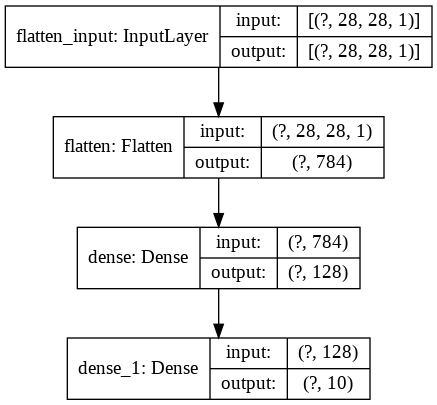

In [1]:
import IPython
IPython.display.Image("figs/lnn.png")

### 2.b. Specifying a loss function, optimizer, and evaluation metrics

To train a model with the `fit` function, you need to specify a loss function, an optimizer, and optionally, some metrics to monitor.

You can pass information about your choices to the model as arguments to the `compile()` method.

To probe more on the `compile()` method see are [here](https://www.tensorflow.org/guide/keras/train_and_evaluate#specifying_a_loss_metrics_and_an_optimizer).

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

### 2.c. Training and visualizing your model

You need to pass the training dataset, number of training epochs, and the validation dataset to train and evaluate your model.

When training by using the `fit()` function, adding the `tf.keras.callbacks.TensorBoard` callback logs are created and stored. Additionally, enable the histogram computation every epoch with `histogram_freq=1` (this is off by default).

`histogram_freq`: frequency (in epochs) at which to compute activation and weight histograms for the layers of the model. If set to 0, histograms won't be computed. Validation data (or split) must be specified for histogram visualizations.

In [0]:
timenow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = "logs/fit/" + timenow
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
    callbacks=[tensorboard_callback]
)

You may open TensorBoard using the following magic command (we pass the path to the tensorflow logging files which are in `logs/fit` as we specified in the last code cell above):

In [0]:
%tensorboard --logdir logs/fit

![tensorboard](https://github.com/tensorflow/tensorboard/blob/master/docs/images/quickstart_model_fit.png?raw=1)

## Step 3: Save your model

`tf.keras.models.save_model` saves the model as a TensorFlow SavedModel or HDF5 file.

In [0]:
saved_model_file = "models/" + timenow
tf.keras.models.save_model(model, saved_model_file)

## Exercises

Here are some exercises that you may try on your own:

1. Change the hidden layer to a convolutional layer and train your model again. Compare the accuracies of the two models on the validation set.

2. Use the `SGD` optimizer instead of `Adam` and compare the training losses and the validation losses.

3. In Step 2.c above, we log the training process by creating a TensorBoard callback. We can also create other callbacks to customize the model during training, evaluation, and inference, e.g. including reading/changing the Keras model. Use the callback to stop training the model whenever the training loss is less than 0.1

## References


Introduction to TensorFlow 2.x
* [Effective TensorFlow 2](https://www.tensorflow.org/guide/effective_tf2)
* [Introduction to TensorFlow 2.0: Easier for beginners, and more powerful for experts](https://www.youtube.com/watch?v=5ECD8J3dvDQ), TF World 2019 conference

TensorFlow Keras
* https://www.tensorflow.org/guide/keras/overview